This notebook calculates all of the SNeCO CDFs, 
some stats about the fraction of CO emission at 150 pc and 
writes the SNeCDFs to a fits file and writes 6 versions of the allPixel CDFs to a fits file. 

'../Data/3.2a.SNeCDFs.fits'

SNeCDFs = {'Detections','NonDetections','DetectionsII','NonDetectionsII','DetectionsIa','NonDetectionsIa'  : 'DetectionsIbc','NonDetectionsIbc','DetectionsUnC','NonDetectionsUnC'}

each of these rows holds CDFdetection,ydetection,CDFdetection_mgsd_ca,ydetection_mgsd_ca,CDFdetection_mgsd_mda,ydetection_mgsd_mda

'../Data/3.2a_CDFAllPixelsInts.fits'           :   CDFAllPixelsInts, yAllPixelsInts
'../Data/3.2a_CDFAllPixelsLims.fits'           :   CDFAllPixelsLims, yAllPixelsLims
'../Data/3.2a_CDFAllPixelsInts_ca.fits'        :   CDFAllPixelsInts_ca, yAllPixelsInts_ca
'../Data/3.2a_CDFAllPixelsLims_ca.fits'        :   CDFAllPixelsLims_ca, yAllPixelsLims_ca
'../Data/3.2a_CDFAllPixelsInts_mgsd_mda.fits'  :   CDFAllPixelsInts_mgsd_mda, yAllPixelsInts_mgsd_mda
'../Data/3.2a_CDFAllPixelsLims_mgsd_mda.fits'  :   CDFAllPixelsLims_mgsd_mda, yAllPixelsLims_mgsd_mda


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from astropy import table
from astropy.table import Table, join
from astropy.io import ascii
import astropy.io.fits as pyfits

import os

import sys
sys.path.append('/home/mayker.1/Desktop/PythonFunctions')
#sys.path.append('/Users/nessmayker/Desktop/NessPythonFunctions')
from detectionFraction import detecFrac
from cumulativeDistFunc import makeCDF
from findPercentiles import findStats
from flattenList import flatten
from nonZeroError import findErrVals
from findAtIndex import findClosest

#import SNe data 

SNe_Gal_File = '../Data/3.SNe+GalData.csv'
SNe_Gal_Data = Table.read(SNe_Gal_File, format='csv') 

intenFile = '../Data/3.IntenData.csv'
intenData = Table.read(intenFile, format='csv')

database  = join(SNe_Gal_Data, intenData, keys=('SN_name', 'galaxy'))


In [2]:
database.sort('galaxy')
database[0:1]

# for i in range(len(database)):
#     print(database["SN_type"][i])

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,ImageFile150,ErrFile150,AlphaCOFile,PACovFile,IFRFile,MixedMaps,IFRResizedMaps,MassMaps,NatRes,NatInt,pc60Int,pc90Int,pc120Int,pc150Int,pc500Int,pc750Int,pc1000Int,NatErr,pc60Err,pc90Err,pc120Err,pc150Err,pc500Err,pc750Err,pc1000Err,NatEW,pc60EW,pc90EW,pc120EW,pc150EW,pc500EW,pc750EW,pc1000EW,NatSNR,pc60SNR,pc90SNR,pc120SNR,pc150SNR,pc500SNR,pc750SNR,pc1000SNR,alphaCO,pc60mgsd,pc90mgsd,pc120mgsd,pc150mgsd,pc500mgsd,pc750mgsd,pc1000mgsd,pc60mgsdErr,pc90mgsdErr,pc120mgsdErr,pc150mgsdErr,pc500mgsdErr,pc750mgsdErr,pc1000mgsdErr
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,str112,str113,str80,str112,str97,str37,str54,str35,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
circinus,SN1996cr,II,213.2918,-65.3457,86.56761411031889,84.63433198287285,186.84804,2.137819,34.56537,0.002032163908078,213.29124,-65.33915,4.2,36.74,64.3,262.49515,7m+tp,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_emom0.fits,/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/ESO097-013_alphaCO21_scaling.fits,/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_coverage2d.fits,/data/tycho/0/leroy.42/projects/phangs_survey_2019/working_data/z0mgs/eso097-013_w1_gauss7p5.fits,../Data/MixedMaps/circinus_Mixed.fits,../Data/ReprojectedInfraredMaps/circinus_reshaped.fits,../Data/MassMaps/circinus_Mass.fits,148.96539476404914,186.84803771972656,nan,nan,nan,186.84803771972656,111.39796447753906,97.68943786621094,81.1122817993164,2.1378190517425537,nan,nan,nan,2.1378190517425537,0.24664470553398132,0.17664189636707306,0.16147032380104065,34.56536865234375,nan,nan,nan,34.56536865234375,49.76144790649414,69.42247772216797,86.25480651855469,87.40124079604642,nan,nan,nan,87.40124079604642,451.65358095307374,553.036623107839,502.3355368956884,4.968773833170559,nan,nan,nan,402.6115402289611,240.03519974851744,210.4966984047925,174.77700651956354,nan,nan,nan,4.606473964923083,0.5314586441272052,0.3806198172227499,0.34792881188466773


In [3]:
# Find which SNe have nan values and which have finite
nans   = np.argwhere(np.isnan(database["pc150Int"]))
finite = np.argwhere(np.isfinite(database["pc150Int"]))

numSNe    = len(database["pc150Int"])
numFinite = len(finite)
numNans   = len(nans)

# Create array of intensity, error, & SNR values where measurements are finite
SNRvalues    = database["pc150SNR"][finite]
values       = database["pc150Int"][finite]
errors       = database["pc150Err"][finite]
alphaCO_Sun  = database["alphaCO"][finite]
incls        = database["orient_incl"][finite]

# change NGC4945's inclination from 90 to 85 and take cosine for incl factor 
incls = np.clip(incls, 0,85)
cosi = np.cos(incls*np.pi/180)

# Find which are considered non-detections and which are detections
detections_idx, um    = np.where(SNRvalues >= 3.0)
nondetections_idx, um = np.where(SNRvalues < 3.0)

detections_int    = flatten(values[detections_idx])

nondetections_int = flatten(values[nondetections_idx])

numDetect    = len(detections_int)
numNonDetect = len(nondetections_int)

# assign nondetections upper limits as a value of 3x the noise.
nondetections_ul = flatten(3 * errors[nondetections_idx])

print("Out of", numSNe, "supernovae,", numFinite, "or", round(numFinite/numSNe*100, 0), "percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.")
print("Out of these,", numDetect, "or", round(numDetect/numFinite*100, 0), "percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.")
print("The remaining", numNonDetect, "are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.")


Out of 63 supernovae, 59 or 94.0 percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.
Out of these, 34 or 58.0 percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.
The remaining 25 are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.


In [4]:
# for i in range(len(database["SN_type"][finite])):
#     print(database["SN_type"][finite][i])
# print(i)

In [5]:
# Sort measurements by SN Type and separate detections from nondetections.

SNtypes = database["SN_type"][finite]

typeII_idx, um    = np.where(SNtypes=="II")
typeIa_idx, um    = np.where(SNtypes=="Ia")
typeIb_idx, um    = np.where(SNtypes=="Ib")
typeIc_idx, um    = np.where(SNtypes=="Ic")
typeIIb_idx, um   = np.where(SNtypes=="IIb")

typeSESN_idx = np.concatenate((typeIb_idx, typeIc_idx, typeIIb_idx), axis = 0)
typeSESN_idx.sort()  

typeI_idx, um = np.where(SNtypes=="I")
typeUnk_idx, um = np.where(SNtypes=="unclassified")
typeUnC_idx = np.concatenate((typeI_idx, typeUnk_idx), axis = 0)
typeUnC_idx.sort()

numTypeII  = len(typeII_idx)
numTypeIa  = len(typeIa_idx)
numTypeSESN = len(typeSESN_idx)
numTypeUnC = len(typeUnC_idx)
numTypeIIb = len(typeIIb_idx)
numTypeIb = len(typeIb_idx)
numTypeIc = len(typeIc_idx)


print("Type II: ",numTypeII)
print("Type Ia: ",numTypeIa)
print("SESNe: ",numTypeSESN)
print("Unclassified: ",numTypeUnC)
print("Type IIb: ",numTypeIIb)
print("Type Ib: ",numTypeIb)
print("Type Ic: ",numTypeIc)
print(len(SNtypes))

Type II:  32
Type Ia:  12
SESNe:  8
Unclassified:  7
Type IIb:  1
Type Ib:  2
Type Ic:  5
59


In [6]:
def findSignal(typeIdx, values=values, errors=errors, detectionIdx = detections_idx, nondetectionIdx = nondetections_idx):
    typeDetectIdx    = np.intersect1d(typeIdx, detectionIdx)
    typeNonDetectIdx = np.intersect1d(typeIdx, nondetectionIdx)
    numDetect    = len(typeDetectIdx)
    numNonDetect = len(typeNonDetectIdx)
    detectionsInt   = flatten(values[typeDetectIdx])
    nondetectionsUL = flatten(3 * errors[typeNonDetectIdx])
    return(typeDetectIdx, typeNonDetectIdx, numDetect, numNonDetect, detectionsInt, nondetectionsUL)

# find indicies of each SN type where there is both a detection and nondetection
typeII_d_Idx, typeII_nd_Idx, numtypeII_d, numtypeII_nd, detectionsII_int, nondetectionsII_ul = findSignal(typeII_idx)
typeIa_d_Idx, typeIa_nd_Idx, numtypeIa_d, numtypeIa_nd, detectionsIa_int, nondetectionsIa_ul = findSignal(typeIa_idx)
typeSESN_d_Idx, typeSESN_nd_Idx, numtypeSESN_d, numtypeSESN_nd, detectionsSESN_int, nondetectionsSESN_ul = findSignal(typeSESN_idx)
typeUnC_d_Idx, typeUnC_nd_Idx, numtypeUnC_d, numtypeUnC_nd, detectionsUnC_int, nondetectionsUnC_ul = findSignal(typeUnC_idx)
typeIIb_d_Idx, typeIIb_nd_Idx, numtypeIIb_d, numtypeIIb_nd, detectionsIIb_int, nondetectionsIIb_ul = findSignal(typeIIb_idx)
typeIb_d_Idx, typeIb_nd_Idx, numtypeIb_d, numtypeIb_nd, detectionsIb_int, nondetectionsIb_ul = findSignal(typeIb_idx)
typeIc_d_Idx, typeIc_nd_Idx, numtypeIc_d, numtypeIc_nd, detectionsIc_int, nondetectionsIc_ul = findSignal(typeIc_idx)

# This is how to access these indexed lists
# print(database["SN_type"][finite][typeIIdetections_idx])

print("We have ", round(numtypeII_d/numTypeII * 100,0), "percent CO 2-1 detections at the location of our",  numTypeII, "typeII SNe.")
print("We have ", round(numtypeIa_d/numTypeIa * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIa, "typeIa SNe.")
print("We have ", round(numtypeSESN_d/numTypeSESN * 100,0), "percent CO 2-1 detections at the location of our",  numTypeSESN, "SESNe.")
print("We have ", round(numtypeUnC_d/numTypeUnC * 100,0), "percent CO 2-1 detections at the location of our",  numTypeUnC, "untyped SNe.")
print("We have ", round(numtypeIIb_d/numTypeIIb * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIIb, "Type IIb SNe.")
print("We have ", round(numtypeIb_d/numTypeIb * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIb, "Type Ib SNe.")
print("We have ", round(numtypeIc_d/numTypeIc * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIc, "Type Ic SNe.")



We have  53.0 percent CO 2-1 detections at the location of our 32 typeII SNe.
We have  33.0 percent CO 2-1 detections at the location of our 12 typeIa SNe.
We have  88.0 percent CO 2-1 detections at the location of our 8 SESNe.
We have  86.0 percent CO 2-1 detections at the location of our 7 untyped SNe.
We have  100.0 percent CO 2-1 detections at the location of our 1 Type IIb SNe.
We have  50.0 percent CO 2-1 detections at the location of our 2 Type Ib SNe.
We have  100.0 percent CO 2-1 detections at the location of our 5 Type Ic SNe.


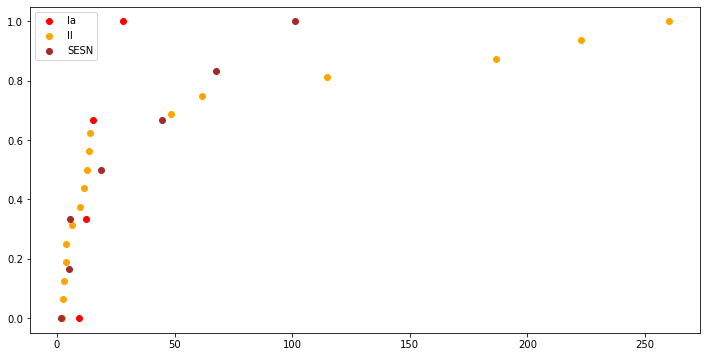

In [7]:
#numtypeII_d, numtypeII_nd, detectionsII_int, nondetectionsII_ul

def makeYs(numD, numND):
    yD  = np.linspace(0.0,1.0, numD)
    yND = np.linspace(0.0,1.0, numND)
    return(yD, yND)


yIa_d, yIa_nd = makeYs(numtypeIa_d, numtypeIa_nd)
yII_d, yII_nd = makeYs(numtypeII_d, numtypeII_nd)
yIb_d, yIb_nd = makeYs(numtypeIb_d, numtypeIb_nd)
yIc_d, yIc_nd = makeYs(numtypeIc_d, numtypeIc_nd)
yIIb_d, yIIb_nd = makeYs(numtypeIIb_d, numtypeIIb_nd)
ySESN_d, ySESN_nd = makeYs(numtypeSESN_d, numtypeSESN_nd)
yUnC_d, yUnC_nd = makeYs(numtypeUnC_d, numtypeUnC_nd)


plt.figure(figsize = (12,6))
plt.scatter(np.sort(detectionsIa_int), yIa_d, label = "Ia", color = "red")
#plt.scatter(np.sort(nondetectionsIa_ul), yIa_nd, color = "red", marker = "<")
plt.scatter(np.sort(detectionsII_int), yII_d, label = "II", color = "orange")
#plt.scatter(np.sort(nondetectionsII_ul), yII_nd, color = "orange", marker = "<")
# plt.scatter(np.sort(detectionsIb_int), yIb_d, label = "Ib", color = "gold")
# plt.scatter(np.sort(nondetectionsIb_ul), yIb_nd, color = "gold", marker = "<")
# plt.scatter(np.sort(detectionsIc_int), yIc_d, label = "Ic", color = "green")
# plt.scatter(np.sort(nondetectionsIc_ul), yIc_nd, color = "green", marker = "<")
# plt.scatter(np.sort(detectionsIIb_int), yIIb_d, label = "IIb", color = "blue")
# plt.scatter(np.sort(nondetectionsIIb_ul), yIIb_nd, color = "blue", marker = "<")
# plt.scatter(np.sort(detectionsIIn_int), yIIn_d, label = "IIn", color = "purple")
# plt.scatter(np.sort(nondetectionsIIn_ul), yIIn_nd, color = "purple", marker = "<")
plt.scatter(np.sort(detectionsSESN_int), ySESN_d, label = "SESN", color = "brown")
#plt.scatter(np.sort(nondetectionsSESN_ul), ySESN_nd, color = "brown", marker = "<")
#plt.scatter(np.sort(detectionsUnC_int), yUnC_d, label = "UnC", color = "black")
# plt.scatter(np.sort(nondetectionsUnC_ul), yUnC_nd, color = "black", marker = "<")

plt.legend(loc='best')

In [8]:
# # Make CDFs of detections and by each type.

frac = numNonDetect/numFinite
fracII = numtypeII_nd/numTypeII
fracIa = numtypeIa_nd/numTypeIa
fracSESN = numtypeSESN_nd/numTypeSESN
fracUnC = numtypeUnC_nd/numTypeUnC

def yStart(numSample):
    start = 1.0/numSample
    return(start)

startAll = yStart(numFinite)       
CDFdetection, ydetection       = makeCDF(detections_int, min=frac+startAll)
CDFnondetection, ynondetection = makeCDF(nondetections_ul, min = startAll, max=frac)

startII = yStart(numTypeII)      
CDFdetectionII, ydetectionII      = makeCDF(detectionsII_int, min=fracII+startII)
CDFnondetectionII, ynondetectionII = makeCDF(nondetectionsII_ul, min = startII, max=fracII)

startIa = yStart(numTypeIa)       
CDFdetectionIa, ydetectionIa      = makeCDF(detectionsIa_int, min=fracIa+startIa)
CDFnondetectionIa, ynondetectionIa = makeCDF(nondetectionsIa_ul, min = startIa, max=fracIa)

startSESN = yStart(numTypeSESN)       
CDFdetectionSESN, ydetectionSESN      = makeCDF(detectionsSESN_int, min=fracSESN+startSESN)
CDFnondetectionSESN, ynondetectionSESN = makeCDF(nondetectionsSESN_ul, min = startSESN, max=fracSESN)

startUnC = yStart(numTypeUnC)       
CDFdetectionUnC, ydetectionUnC      = makeCDF(detectionsUnC_int, min=fracUnC+startUnC)
CDFnondetectionUnC, ynondetectionUnC = makeCDF(nondetectionsUnC_ul, min = startUnC, max=fracUnC)


In [9]:
print(len(CDFdetection))


34


In [10]:
# Convert to molecular gas surface density using Sun+20 alphaCO

detections_mgsd_mda       = [a*b*c for a,b,c in zip(detections_int, flatten(alphaCO_Sun[detections_idx]), flatten(cosi[detections_idx]))]
nondetections_mgsd_mda    = [a*b*c for a,b,c in zip(nondetections_ul, flatten(alphaCO_Sun[nondetections_idx]), flatten(cosi[nondetections_idx]))]

detectionsII_mgsd_mda     = [a*b*c for a,b,c in zip(detectionsII_int, flatten(alphaCO_Sun[typeII_d_Idx]), flatten(cosi[detections_idx]))]
nondetectionsII_mgsd_mda  = [a*b*c for a,b,c in zip(nondetectionsII_ul, flatten(alphaCO_Sun[typeII_nd_Idx]), flatten(cosi[nondetections_idx]))]

detectionsIa_mgsd_mda     = [a*b*c for a,b,c in zip(detectionsIa_int, flatten(alphaCO_Sun[typeIa_d_Idx]), flatten(cosi[detections_idx]))]
nondetectionsIa_mgsd_mda  = [a*b*c for a,b,c in zip(nondetectionsIa_ul, flatten(alphaCO_Sun[typeIa_nd_Idx]), flatten(cosi[nondetections_idx]))]

detectionsSESN_mgsd_mda    = [a*b*c for a,b,c in zip(detectionsSESN_int, flatten(alphaCO_Sun[typeSESN_d_Idx]), flatten(cosi[detections_idx]))]
nondetectionsSESN_mgsd_mda = [a*b*c for a,b,c in zip(nondetectionsSESN_ul, flatten(alphaCO_Sun[typeSESN_nd_Idx]), flatten(cosi[nondetections_idx]))]

detectionsUnC_mgsd_mda    = [a*b*c for a,b,c in zip(detectionsUnC_int, flatten(alphaCO_Sun[typeUnC_d_Idx]), flatten(cosi[detections_idx]))]
nondetectionsUnC_mgsd_mda = [a*b*c for a,b,c in zip(nondetectionsUnC_ul, flatten(alphaCO_Sun[typeUnC_nd_Idx]), flatten(cosi[nondetections_idx]))]

CDFdetection_mgsd_mda, ydetection_mgsd_mda       = makeCDF(detections_mgsd_mda, min=frac+startAll)
CDFnondetection_mgsd_mda, ynondetection_mgsd_mda = makeCDF(nondetections_mgsd_mda, min = startAll, max=frac)

CDFdetectionII_mgsd_mda, ydetectionII_mgsd_mda      = makeCDF(detectionsII_mgsd_mda, min=fracII+startII)
CDFnondetectionII_mgsd_mda, ynondetectionII_mgsd_mda = makeCDF(nondetectionsII_mgsd_mda, min = startII, max=fracII)

CDFdetectionIa_mgsd_mda, ydetectionIa_mgsd_mda      = makeCDF(detectionsIa_mgsd_mda, min=fracIa+startIa)
CDFnondetectionIa_mgsd_mda, ynondetectionIa_mgsd_mda = makeCDF(nondetectionsIa_mgsd_mda, min = startIa, max=fracIa)

CDFdetectionSESN_mgsd_mda, ydetectionSESN_mgsd_mda      = makeCDF(detectionsSESN_mgsd_mda, min=fracSESN+startSESN)
CDFnondetectionSESN_mgsd_mda, ynondetectionSESN_mgsd_mda = makeCDF(nondetectionsSESN_mgsd_mda, min = startSESN, max=fracSESN)

CDFdetectionUnC_mgsd_mda, ydetectionUnC_mgsd_mda      = makeCDF(detectionsUnC_mgsd_mda, min=fracUnC+startUnC)
CDFnondetectionUnC_mgsd_mda, ynondetectionUnC_mgsd_mda = makeCDF(nondetectionsUnC_mgsd_mda, min = startUnC, max=fracUnC)



In [11]:
print(detections_mgsd_mda)
print(alphaCO_Sun)
print(CDFdetection_mgsd_mda)



[402.6115402289611, 254.2846041302592, 61.94105039229683, 724.2985069714374, 15.625984854643244, 9.617132316234608, 28.199893992949395, 61.11356289363785, 230.24792564528673, 18.259729969537936, 379.2393952429976, 81.78842185941642, 323.91344103178244, 36.162421253305, 12.134357853733233, 77.17962993549692, 70.12872783066938, 19.550158419024072, 49.187835531525764, 186.41780739482363, 31.41987376544035, 34.946483611677635, 62.405649923019354, 76.85340347417463, 55.458437209076784, 28.19141591902129, 31.68597014473837, 206.28816179855477, 13.880296559186945, 887.0885658286992, 9.159460320075235, 305.856934288958, 133.95004148247523, 18.937336544394704]
   alphaCO [1]    
------------------
 4.968773833170559
 4.479999295527333
 7.274922328334363
 6.629858070576079
 4.206428083333224
10.912807259453894
6.1035414066894775
 5.226342740029572
 4.810275129364102
 5.304207211252953
               ...
               6.7
 4.838774135471994
4.3425294426087335
   5.9682341177841
 4.35620192997292

In [12]:

SNeCDFs = Table({'Detections'      : [CDFdetection,ydetection,CDFdetection_mgsd_mda,ydetection_mgsd_mda],
                'NonDetections'    : [CDFnondetection,ynondetection,CDFnondetection_mgsd_mda,ynondetection_mgsd_mda],
                'DetectionsII'     : [CDFdetectionII,ydetectionII,CDFdetectionII_mgsd_mda,ydetectionII_mgsd_mda],
                'NonDetectionsII'  : [CDFnondetectionII,ynondetectionII,CDFnondetectionII_mgsd_mda,ynondetectionII_mgsd_mda],
                'DetectionsIa'     : [CDFdetectionIa,ydetectionIa,CDFdetectionIa_mgsd_mda,ydetectionIa_mgsd_mda],
                'NonDetectionsIa'  : [CDFnondetectionIa,ynondetectionIa,CDFnondetectionIa_mgsd_mda,ynondetectionIa_mgsd_mda],
                'DetectionsSESN'    : [CDFdetectionSESN,ydetectionSESN,CDFdetectionSESN_mgsd_mda,ydetectionSESN_mgsd_mda],
                'NonDetectionsSESN' : [CDFnondetectionSESN,ynondetectionSESN,CDFnondetectionSESN_mgsd_mda,ynondetectionSESN_mgsd_mda] ,
                'DetectionsUnC'    : [CDFdetectionUnC,ydetectionUnC,CDFdetectionUnC_mgsd_mda,ydetectionUnC_mgsd_mda],
                'NonDetectionsUnC' : [CDFnondetectionUnC,ynondetectionUnC,CDFnondetectionUnC_mgsd_mda,ynondetectionUnC_mgsd_mda]})


SNeCDFs.write('../Data/3.2a.SNeCDFs.fits', overwrite=True)



In [13]:
# Print average statements in section 3.2

allSNe = np.concatenate((CDFnondetection_mgsd_mda, CDFdetection_mgsd_mda), axis = 0)
ave_allSNe = np.average(allSNe)
ave_SNe = np.average(CDFdetection_mgsd_mda)

print("Average of mgsd at all SN locations: ", np.round(ave_allSNe,2), "Average of mgsd at SN locations with detections: ", np.round(ave_SNe,2))

allSNeII = np.concatenate((CDFnondetectionII_mgsd_mda, CDFdetectionII_mgsd_mda), axis = 0)
ave_allSNeII = np.average(allSNeII)
ave_SNeII = np.average(CDFdetectionII_mgsd_mda)

print("Average of mgsd at all SNe II locations: ", np.round(ave_allSNeII,2), "Average of mgsd at SN locations with detections: ", np.round(ave_SNeII,2))

allSNeIa = np.concatenate((CDFnondetectionIa_mgsd_mda, CDFdetectionIa_mgsd_mda), axis = 0)
ave_allSNeIa = np.average(allSNeIa)
ave_SNeIa = np.average(CDFdetectionIa_mgsd_mda)

print("Average of mgsd at all SNe Ia locations: ", np.round(ave_allSNeIa,2), "Average of mgsd at SN locations with detections: ", np.round(ave_SNeIa,2))

allSNeSESN = np.concatenate((CDFnondetectionSESN_mgsd_mda, CDFdetectionSESN_mgsd_mda), axis = 0)
ave_allSNeSESN = np.average(allSNeSESN)
ave_SNeSESN = np.average(CDFdetectionSESN_mgsd_mda)

print("Average of mgsd at all SESNe locations: ", np.round(ave_allSNeSESN,2), "Average of mgsd at SN locations with detections: ", np.round(ave_SNeSESN,2))

allSNeUnC = np.concatenate((CDFnondetectionUnC_mgsd_mda, CDFdetectionUnC_mgsd_mda), axis = 0)
ave_allSNeUnC = np.average(allSNeUnC)
ave_SNeUnC = np.average(CDFdetectionUnC_mgsd_mda)

print("Average of mgsd at all SNe Unclassified locations: ", np.round(ave_allSNeUnC,2), "Average of mgsd at SN locations with detections: ", np.round(ave_SNeUnC,2))
print()


Average of mgsd at all SN locations:  88.66 Average of mgsd at SN locations with detections:  145.24
Average of mgsd at all SNe II locations:  103.6 Average of mgsd at SN locations with detections:  183.82
Average of mgsd at all SNe Ia locations:  17.39 Average of mgsd at SN locations with detections:  34.95
Average of mgsd at all SESNe locations:  69.01 Average of mgsd at SN locations with detections:  75.86
Average of mgsd at all SNe Unclassified locations:  116.43 Average of mgsd at SN locations with detections:  133.35



In [14]:
#!pip install reproject
from reproject import reproject_interp
########### GETTING ALL PIXEL VALUES HERE #################

# filename: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc2997/ngc2997_12m+7m+tp_co21_150pc_broad_mom0.fits

# Isolate unique galaxy names
unique_by_name = table.unique(database, keys='galaxy')
galaxyName, intfile, errfile, acofile, distance, cosis = [],[],[],[],[],[]

# Create list of Filenames
for i in range(len(unique_by_name)):
    prefix = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/"
    galaxy = unique_by_name['galaxy'][i]
    telOrient = unique_by_name['telOrient'][i]
    int_suffix = "_co21_150pc_broad_mom0.fits"
    err_suffix = "_co21_150pc_broad_emom0.fits"
    intname =  prefix + galaxy + "/" + galaxy + "_" + telOrient + int_suffix
    errname =  prefix + galaxy + "/" + galaxy + "_" + telOrient + err_suffix
    
    dist = unique_by_name["dist"][i]
    incl = unique_by_name["orient_incl"][i]
    if incl == 90:
        incl = 85
    cosi = np.cos(incl*np.pi/180)
    
    GalName = galaxy.strip().upper()
    
    if GalName == 'CIRCINUS':
        GalName = 'ESO097-013'
        
    aconame =  "/data/kant/0/sun.1608/PHANGS/ALMA/alphaCO/v1p0/" + GalName + '_alphaCO21_scaling.fits'
    
    intfile.append(intname)
    errfile.append(errname)
    acofile.append(aconame) 
    galaxyName.append(galaxy)
    distance.append(dist)
    cosis.append(cosi)
    
# Pull intensity values out of galaxy maps for CDF and assign them as three sigma measurements or below

allIntensities, allErrors, allAcos = [],[],[]
detectionInts, nonDetectionInts, detectionSigmaMol, nonDetectionSigmaMol, detectionMass, nonDetectionMass = [],[],[],[],[],[]
detectionSigmaMolPerPixel, nonDetectionSigmaMolPerPixel, detectionMassPerPixel, nonDetectionMassPerPixel = [],[],[],[]
threeSigmaSigma, threeSigmaMass, allSigmaMol = [],[],[]

for i in range(len(intfile)):
    galaxy = galaxyName[i]
    
    if os.path.isfile(intfile[i]):
        
        hdu_int  = pyfits.open(intfile[i])
        hdu_err  = pyfits.open(errfile[i])
      
        cdelt1, cdelt2, distance_mpc = np.abs(hdu_int[0].header['CDELT1']), np.abs(hdu_int[0].header['CDELT2']), distance[i]
        pixelArea = cdelt1*cdelt2 * (np.pi/180.0 * distance_mpc * 10**6)**2
        beamArea = (150.0/2.0)**2*np.pi/np.log(2.0)
        pixelsPerBeam = beamArea/pixelArea
        #print(pixelsPerBeam)
    
        intmap   = hdu_int[0].data 
        errmap   = hdu_err[0].data 
        
        f_int    = intmap.flatten()
        f_err    = errmap.flatten()
        
        keep     = np.where(np.isfinite(f_int))
        inten    = f_int[keep]
        error    = f_err[keep]
        
        lowErr = findErrVals(error)
        
        for j in range(len(error)):
            
            if error[j] <= lowErr:
                error[j] == lowErr
            
            elif np.isnan(error[j]):
                error[j] == lowErr
            
            else:
                pass
            
        if os.path.isfile(acofile[i]):
            
            hdu_aco  = pyfits.open(acofile[i])
            
            acomap, footprint = reproject_interp(hdu_aco, hdu_int[0].header) 

            f_aco    = acomap.flatten()
            alphaCO  = f_aco[keep]
                    
            for j in range(len(alphaCO)):

                if np.isnan(alphaCO[j]):
                    alphaCO[j] = 6.7

                else:
                    pass
                
        else: alphaCO = np.full(len(inten),6.7,dtype=float)
            
        for j in range(len(inten)):
            allIntensities.append(inten[j])
            allErrors.append(error[j])
            allAcos.append(alphaCO[j])
            threeSigmaMass.append(3*error[j]*cosis[i]*alphaCO[j]*beamArea)
            threeSigmaSigma.append(3*error[j]*cosis[i]*alphaCO[j])
            allSigmaMol.append(inten[j] * alphaCO[j] * cosis[i])

        
            if inten[j] < 0.0:
                nonDetectionInts.append(0.0)
                nonDetectionSigmaMol.append(0.0)
                nonDetectionMass.append(0.0)
                nonDetectionSigmaMolPerPixel.append(0.0)
                nonDetectionMassPerPixel.append(0.0)
            
            elif inten[j]/error[j] <= 3.0:
                nonDetectionInts.append(3 * error[j])
                nonDetectionSigmaMol.append(3 * error[j] * alphaCO[j]* cosis[i])
                nonDetectionMass.append(3 * error[j] * alphaCO[j] * cosis[i] * beamArea)
                nonDetectionSigmaMolPerPixel.append(3 * error[j] * alphaCO[j] * cosis[i] / pixelsPerBeam)
                nonDetectionMassPerPixel.append(3 * error[j] * alphaCO[j] * cosis[i] * beamArea / pixelsPerBeam)
            
            else:
                detectionInts.append(inten[j])
                detectionSigmaMol.append(inten[j] * alphaCO[j] * cosis[i])
                detectionMass.append(inten[j] * alphaCO[j] * cosis[i] * beamArea)
                detectionSigmaMolPerPixel.append(inten[j] * alphaCO[j] * cosis[i] / pixelsPerBeam)
                detectionMassPerPixel.append(inten[j] * alphaCO[j] * cosis[i] * beamArea / pixelsPerBeam)   
# This code will be used to evaluate percentiles for each galaxy, will need to add in detections and upper limits.                
#             galaxyPixelData = Table({"Intensities": inten,
#                                      "Errors": error,
#                                      "Acos": alphaCO})

#             fileName = "../Data/GalaxyVals/" + galaxy + "/AllPixelData.csv"
#             ascii.write(galaxyPixelData, fileName, format = "csv", fast_writer=False, overwrite = True)

    else:
        print(intfile[i])
        print("No 150pc file for", unique_by_name['galaxy'][i])

# Print these into SNeCO Large Data in the future, files too big
# allGalaxiesPixelData = Table({"Intensities": allIntensities,
#                           "Errors": allErrors,
#                           "Acos": allAcos,
#                           "ThreeSigmas": threeSigma})

# allGalaxiesNonDetectionData = Table({"NonDetectionInts": nonDetectionInts,
#                           "NonDetectionSigmaMol": nonDetectionSigmaMol,
#                           "NonDetectionMass": nonDetectionMass,
#                           "NonDetectionSigmaMolPerPixel": nonDetectionSigmaMolPerPixel,
#                           "NonDetectionMassPerPixel": nonDetectionMassPerPixel})

# allGalaxiesDetectionData = Table({"DetectionInts": detectionInts,
#                           "DetectionSigmaMol": detectionSigmaMol,
#                           "DetectionMass": detectionMass,
#                           "DetectionSigmaMolPerPixel": detectionSigmaMolPerPixel,
#                           "DetectionMassPerPixel": detectionMassPerPixel})

# fileName = "../Data/GalaxyVals/AllPixelData.csv"
# ascii.write(allGalaxiesPixelData, fileName, format = "csv", fast_writer=False, overwrite = True)
# fileName = "../Data/GalaxyVals/AllNonDetectionData.csv"
# ascii.write(allGalaxiesNonDetectionData, fileName, format = "csv", fast_writer=False, overwrite = True)    
# fileName = "../Data/GalaxyVals/AllDetectionData.csv"
# ascii.write(allGalaxiesDetectionData, fileName, format = "csv", fast_writer=False, overwrite = True)


/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_150pc_broad_mom0.fits
No 150pc file for ngc1068
/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1672/ngc1672_12m+7m+tp_co21_150pc_broad_mom0.fits
No 150pc file for ngc1672
/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc4579/ngc4579_12m+7m+tp_co21_150pc_broad_mom0.fits
No 150pc file for ngc4579


<ipython-input-14-edef64820aee>:110: RuntimeWarning: invalid value encountered in multiply
  allSigmaMol.append(inten[j] * alphaCO[j] * cosis[i])
<ipython-input-14-edef64820aee>:129: RuntimeWarning: invalid value encountered in multiply
  detectionSigmaMol.append(inten[j] * alphaCO[j] * cosis[i])
<ipython-input-14-edef64820aee>:130: RuntimeWarning: invalid value encountered in multiply
  detectionMass.append(inten[j] * alphaCO[j] * cosis[i] * beamArea)
<ipython-input-14-edef64820aee>:131: RuntimeWarning: invalid value encountered in multiply
  detectionSigmaMolPerPixel.append(inten[j] * alphaCO[j] * cosis[i] / pixelsPerBeam)
<ipython-input-14-edef64820aee>:132: RuntimeWarning: invalid value encountered in multiply
  detectionMassPerPixel.append(inten[j] * alphaCO[j] * cosis[i] * beamArea / pixelsPerBeam)


In [15]:
import math
nSM = [x for x in threeSigmaSigma if math.isnan(x) == False and x > 0]
print("Median 3Sigma: ", np.median(nSM))
print("Min 3Sigma: ", np.min(nSM))
print("Max 3Sigma: ", np.max(nSM))


MedianMass = np.nanmedian(threeSigmaMass) 
print(MedianMass)
medMass = np.log10(MedianMass)
print(medMass)

MedianSigmaMol = np.nanmedian(threeSigmaSigma) 
print(MedianSigmaMol)
medSigmaMol = np.log10(MedianSigmaMol)
print(medSigmaMol)

Median 3Sigma:  7.916632435070248
Min 3Sigma:  0.17617842888670862
Max 3Sigma:  inf
201830.78984742422
5.304987419784072
7.916632435070248
0.8985404813516769


In [16]:
#get fraction of pixels with less emission than each SNe per galaxy

# find SNe that have CO measurements at 150pc resolution 
finite = np.isfinite(database["pc150Int"])
SN_name = database["SN_name"][finite]
SN_type = database["SN_type"][finite]
SNInten = database["pc150Int"][finite]
galaxyList  = database["galaxy"][finite]

# calculate the percentile of CO2-1 emission at the location of each supernova from that of the entire galaxy
SN_percentile, SN_Name, SN_gal, SN_int, SN_mgsd, SN_Typ = [],[],[],[],[],[]
for i in range(len(galaxyList)):
    
    # pull all intensity values, all detection values, and all upperlimit values for each galaxy
    galaxy = galaxyList[i]
    intFile = "../Data/GalaxyVals/" + galaxy + "AllInten.csv"
    detFile = "../Data/GalaxyVals/" + galaxy + "_detections.csv" 
    ulsFile = "../Data/GalaxyVals/" + galaxy + "_nondetections.csv" 
    
    if os.path.isfile(intFile):
        # pull intensity, name, type value for each supernova
        SNI = SNInten[i]
        SNT = SN_type[i]
        SNN = SN_name[i]
        
        # sort all the finite CO2-1 measurements from the galaxy map
        intensities = np.loadtxt(intFile)
        notnan = np.isfinite(intensities)
        intenSort = np.sort(intensities[notnan])
        
        # pull the detection and non-detection values for the galaxy
        detTable = Table.read(detFile)
        ulsTable = Table.read(ulsFile)
        detections, mgsd_d = detTable["Intensities"], detTable["MGSDIntensities"] 
        upperlimits, mgsd_ul = ulsTable["UpperLimits"], ulsTable["MGSDUpperLimits"] 
        
        # sort the detection values for the galaxy
        sortDetec = np.sort(detections)
        sortMGSD = np.sort(mgsd_d)
        
        # find where the intensity value of the supernova equals the invensity value of that pixel in the map
        index = np.where(sortDetec == SNI)
#         print(SNI)
#         print(index[0])
        if(len(index[0]))>=1:
            SN_percentile.append(round(float(index[0][-1])/len(sortDetec),2))
#            print(sortDetec[index[0][0]])
        else: 
            SN_percentile.append("non-detection")
        SN_Name.append(SNN)
        SN_gal.append(galaxy)
        SN_Typ.append(SNT)
        SN_int.append(SNI)
        SN_mgsd.append(sortMGSD[index])

for i in range(len(SN_percentile)):
        print(i, SN_gal[i], SN_Name[i], SN_Typ[i], SN_percentile[i], SN_int[i])

        
perTable = Table({"SN_name":SN_Name,
                         "SN_percentile":SN_percentile})
database = join(database, perTable, keys = "SN_name")

for i in range(len(database)):
    print(database[i])


0 circinus SN1996cr II 0.98 186.84803771972656
1 ngc0253 SN1940E I 0.99 219.3036651611328
2 ngc0628 SN2013ej II non-detection 1.341525912284851
3 ngc1087 SN1995V II 0.9 12.753849029541016
4 ngc1097 SN1992bd II 0.99 260.3741149902344
5 ngc1097 SN1999eu II 0.05 0.0
6 ngc1365 SN2001du II non-detection 2.8034262657165527
7 ngc1365 SN1983V Ic 0.24 5.265270233154297
8 ngc1365 SN2012fr Ia non-detection -2.5313384532928467
9 ngc1433 SN1985P II non-detection 0.1435399204492569
10 ngc1511 SN1935C unclassified non-detection 1.6127102375030518
11 ngc1559 SN2009ib II 0.29 3.6781487464904785
12 ngc1559 SN1986L II non-detection 2.06026029586792
13 ngc1559 SN1984J II 0.83 13.627583503723145
14 ngc1559 SN2005df Ia 0.05 0.0
15 ngc1566 SN2010el Ia 0.83 15.370909690856934
16 ngc1566 ASASSN-14ha II 0.98 61.47018814086914
17 ngc1637 SN1999em II 0.76 2.9616308212280273
18 ngc2775 SN1993Z Ia non-detection 0.15208368003368378
19 ngc2997 SN2003jg Ic 1.0 101.05767822265625
20 ngc2997 SN2008eh unclassified 0.92 1

In [17]:
for i in range(len(SN_percentile)):
    print(SN_percentile[i])
    
    
print(len(SN_percentile))
print(SN_percentile)

0.98
0.99
non-detection
0.9
0.99
0.05
non-detection
0.24
non-detection
non-detection
non-detection
0.29
non-detection
0.83
0.05
0.83
0.98
0.76
non-detection
1.0
0.92
0.7
0.99
0.68
0.18
0.89
0.81
0.1
0.72
0.98
non-detection
0.41
non-detection
non-detection
non-detection
non-detection
non-detection
0.56
non-detection
non-detection
0.92
0.91
non-detection
non-detection
0.73
non-detection
0.1
non-detection
0.93
0.65
0.95
0.37
1.0
0.2
0.99
0.96
non-detection
0.75
non-detection
59
[0.98, 0.99, 'non-detection', 0.9, 0.99, 0.05, 'non-detection', 0.24, 'non-detection', 'non-detection', 'non-detection', 0.29, 'non-detection', 0.83, 0.05, 0.83, 0.98, 0.76, 'non-detection', 1.0, 0.92, 0.7, 0.99, 0.68, 0.18, 0.89, 0.81, 0.1, 0.72, 0.98, 'non-detection', 0.41, 'non-detection', 'non-detection', 'non-detection', 'non-detection', 'non-detection', 0.56, 'non-detection', 'non-detection', 0.92, 0.91, 'non-detection', 'non-detection', 0.73, 'non-detection', 0.1, 'non-detection', 0.93, 0.65, 0.95, 0.37, 1.0

In [18]:
ascii.write(database, '../Data/3.SNe+GalData150.csv', format='csv', fast_writer=False, overwrite=True)  

In [19]:
# Make CDFs of all Measurements

sortedDetectionInts                = np.sort(detectionInts)
sortedNonDetectionInts             = np.sort(nonDetectionInts)
sortedDetectionSigmaMol            = np.sort(detectionSigmaMol)
sortedNonDetectionSigmaMol         = np.sort(nonDetectionSigmaMol)
sortedDetectionMass                = np.sort(detectionMass)
sortedNonDetectionMass             = np.sort(nonDetectionMass)
sortedDetectionSigmaMolPerPixel    = np.sort(detectionSigmaMolPerPixel)
sortedNonDetectionSigmaMolPerPixel = np.sort(nonDetectionSigmaMolPerPixel)
sortedDetectionMassPerPixel        = np.sort(detectionMassPerPixel)
sortedNonDetectionMassPerPixel     = np.sort(nonDetectionMassPerPixel)
sortedAllSigmaMol                  = np.sort(allSigmaMol)
print(sortedDetectionInts)

numInts = len(sortedDetectionInts)
numLims = len(sortedNonDetectionInts)
numAll  = numLims+numInts

frac = numLims/(numAll)
start = yStart(numAll)

CDFAllPixelsDetections, yAllPixelsDetections = makeCDF(sortedDetectionInts, min=frac+start)
CDFAllPixelsNonDetections, yAllPixelsNonDetections = makeCDF(sortedNonDetectionInts, min=start, max = frac)

CDFAllPixelsDetectionSigmaMol, yAllPixelsDetectionSigmaMol = makeCDF(sortedDetectionSigmaMol, min=frac+start)
CDFAllPixelsNonDetectionSigmaMol, yAllPixelsNonDetectionSigmaMol = makeCDF(sortedNonDetectionSigmaMol, min=start, max = frac)

CDFAllPixelsDetectionMass, yAllPixelsDetectionMass = makeCDF(sortedDetectionMass, min=frac+start)
CDFAllPixelsNonDetectionMass, yAllPixelsNonDetectionMass = makeCDF(sortedNonDetectionMass, min=start, max = frac)

CDFAllPixelsDetectionSigmaMolPerPixel, yAllPixelsDetectionSigmaMolPerPixel = makeCDF(sortedDetectionSigmaMolPerPixel, min=frac+start)
CDFAllPixelsNonDetectionSigmaMolPerPixel, yAllPixelsNonDetectionSigmaMolPerPixel = makeCDF(sortedNonDetectionSigmaMolPerPixel, min=start, max = frac)

CDFAllPixelsDetectionMassPerPixel, yAllPixelsDetectionMassPerPixel = makeCDF(sortedDetectionMassPerPixel, min=frac+start)
CDFAllPixelsNonDetectionMassPerPixel, yAllPixelsNonDetectionMassPerPixel = makeCDF(sortedNonDetectionMassPerPixel, min=start, max = frac)

print()


[   0.        0.        0.     ... 2286.3303 2299.217  2320.3193]



In [20]:
# Write CDFs to files 
CDFAllPixelsDetections = Table({"CDFAllPixelsDetections":[CDFAllPixelsDetections, yAllPixelsDetections]})
CDFAllPixelsDetections.write('../Data/3.2a_CDFAllPixelsDetections.fits', overwrite = True)

CDFAllPixelsNonDetections = Table({"CDFAllPixelsNonDetections":[CDFAllPixelsNonDetections, yAllPixelsNonDetections]})
CDFAllPixelsNonDetections.write('../Data/3.2a_CDFAllPixelsNonDetections.fits', overwrite = True)

CDFAllPixelsDetectionSigmaMol = Table({"CDFAllPixelsDetectionSigmaMol":[CDFAllPixelsDetectionSigmaMol, yAllPixelsDetectionSigmaMol]})
CDFAllPixelsDetectionSigmaMol.write('../Data/3.2a_CDFAllPixelsDetectionSigmaMol.fits', overwrite = True)

CDFAllPixelsNonDetectionSigmaMol = Table({"CDFAllPixelsNonDetectionSigmaMol":[CDFAllPixelsNonDetectionSigmaMol, yAllPixelsNonDetectionSigmaMol]})
CDFAllPixelsNonDetectionSigmaMol.write('../Data/3.2a_CDFAllPixelsNonDetectionSigmaMol.fits', overwrite = True)

CDFAllPixelsDetectionMass = Table({"CDFAllPixelsDetectionMass":[CDFAllPixelsDetectionMass, yAllPixelsDetectionMass]})
CDFAllPixelsDetectionMass.write('../Data/3.2a_CDFAllPixelsDetectionMass.fits', overwrite = True)

CDFAllPixelsNonDetectionMass = Table({"CDFAllPixelsNonDetectionMass":[CDFAllPixelsNonDetectionMass, yAllPixelsNonDetectionMass]})
CDFAllPixelsNonDetectionMass.write('../Data/3.2a_CDFAllPixelsNonDetectionMass.fits', overwrite = True)

CDFAllPixelsDetectionSigmaMolPerPixel = Table({"CDFAllPixelsDetectionSigmaMolPerPixel":[CDFAllPixelsDetectionSigmaMolPerPixel, yAllPixelsDetectionSigmaMolPerPixel]})
CDFAllPixelsDetectionSigmaMolPerPixel.write('../Data/3.2a_CDFAllPixelsDetectionSigmaMolPerPixel.fits', overwrite = True)

CDFAllPixelsNonDetectionSigmaMolPerPixel = Table({"CDFAllPixelsNonDetectionSigmaMolPerPixel":[CDFAllPixelsNonDetectionSigmaMolPerPixel, yAllPixelsNonDetectionSigmaMolPerPixel]})
CDFAllPixelsNonDetectionSigmaMolPerPixel.write('../Data/3.2a_CDFAllPixelsNonDetectionSigmaMolPerPixel.fits', overwrite = True)

CDFAllPixelsDetectionMassPerPixel = Table({"CDFAllPixelsDetectionMassPerPixel":[CDFAllPixelsDetectionMassPerPixel, yAllPixelsDetectionMassPerPixel]})
CDFAllPixelsDetectionMassPerPixel.write('../Data/3.2a_CDFAllPixelsDetectionMassPerPixel.fits', overwrite = True)

CDFAllPixelsNonDetectionMassPerPixel = Table({"CDFAllPixelsNonDetectionMassPerPixel":[CDFAllPixelsNonDetectionMassPerPixel, yAllPixelsNonDetectionMassPerPixel]})
CDFAllPixelsNonDetectionMassPerPixel.write('../Data/3.2a_CDFAllPixelsNonDetectionMassPerPixel.fits', overwrite = True)


In [21]:
print(CDFAllPixelsDetectionSigmaMol)

CDFAllPixelsDetectionSigmaMol [2974309]
---------------------------------------
                             0.0 .. inf
              0.6446140915793591 .. 1.0


In [22]:
finiteDetec = np.isfinite(sortedDetectionSigmaMol)
allD = sortedDetectionSigmaMol[finiteDetec]
ave_detPixels = np.average(allD)

# allPixels = np.concatenate((sortedNonDetectionSigmaMol, sortedDetectionSigmaMol), axis = 0)
finiteAll = np.isfinite(sortedAllSigmaMol)
allP = sortedAllSigmaMol[finiteAll]
ave_allPixels = np.average(allP)


print("Average of SigMol at all pixels: ", np.round(ave_allPixels,2), "Average of SigMol at pixels with detections: ", np.round(ave_detPixels,2))
print()

finiteDetec = np.isfinite(sortedDetectionSigmaMolPerPixel)
allD = sortedDetectionSigmaMolPerPixel[finiteDetec]
ave_detPixels = np.average(allD)

allPixels = np.concatenate((sortedNonDetectionSigmaMolPerPixel, sortedDetectionSigmaMolPerPixel), axis = 0)
finiteAll = np.isfinite(allPixels)
allP = allPixels[finiteAll]
ave_allPixels = np.average(allP)


print("Average of SigMolPerPixel at all pixels: ", np.round(ave_allPixels,2), "Average of SigMolPerPixel at pixels with detections: ", np.round(ave_detPixels,2))
print()

Average of SigMol at all pixels:  13.33 Average of SigMol at pixels with detections:  33.74

Average of SigMolPerPixel at all pixels:  0.33 Average of SigMolPerPixel at pixels with detections:  0.62



In [23]:
finiteDetec = np.isfinite(sortedDetectionMass)
allD = sortedDetectionMass[finiteDetec]
ave_detPixels = np.average(allD)

allPixels = np.concatenate((sortedNonDetectionMass, sortedDetectionMass), axis = 0)
finiteAll = np.isfinite(allPixels)
allP = allPixels[finiteAll]
ave_allPixels = np.average(allP)


print("Average of Mass at all pixels: ", np.round(ave_allPixels,2), "Average of Mass at pixels with detections: ", np.round(ave_detPixels,2))
print()

finiteDetec = np.isfinite(sortedDetectionMassPerPixel)
allD = sortedDetectionMassPerPixel[finiteDetec]
ave_detPixels = np.average(allD)

allPixels = np.concatenate((sortedNonDetectionMassPerPixel, sortedDetectionMassPerPixel), axis = 0)
finiteAll = np.isfinite(allPixels)
allP = allPixels[finiteAll]
ave_allPixels = np.average(allP)


print("Average of MassPerPixel at all pixels: ", np.round(ave_allPixels,2), "Average of MassPerPixel at pixels with detections: ", np.round(ave_detPixels,2))
print()

Average of Mass at all pixels:  432156.08 Average of Mass at pixels with detections:  860256.61

Average of MassPerPixel at all pixels:  8438.39 Average of MassPerPixel at pixels with detections:  15838.81



In [24]:
print(sortedDetectionMass)
print(cdelt1)

print(cdelt2)

[ 0.  0.  0. ... nan nan nan]
0.0005555555555556
0.0005555555555556
